In [293]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [294]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [295]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)
GALARY = '/tigress/jiaxuanl/public_html/galary/'

In [296]:
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

### Try to plot the difference between UDG and UPG

In [297]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)
import matplotlib.lines as mlines

In [298]:
name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)

In [299]:
np.sum(upg_cat['log_m_star'] > 9) / len(upg_cat)

0.01483679525222552

In [150]:
name = 'udg'
thresh = None
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
udg_cat.sort('g-i', reverse=True)

2.9664845246942417 3.8464845246942425


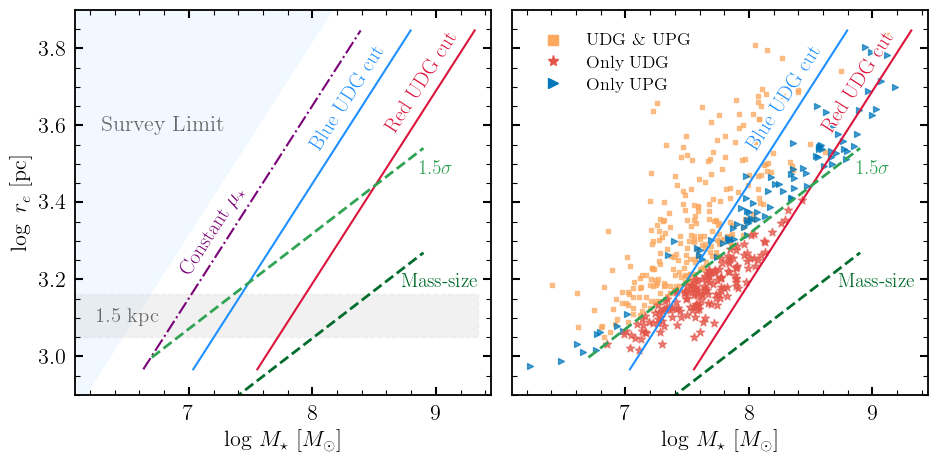

In [163]:
# new one
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11., 5.1), sharey=True, sharex=True)

plt.sca(ax1)


plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_e$ [pc]')
# plt.title(r'UDG')

### SB limit for the survey
dist = 100
g_mag = np.linspace(16.9, 25., 100)
g_abs = g_mag - 25 - 5 * np.log10(dist)
gi = 0.6
log_ML_g = 1.297 * gi - 0.855
log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
SB = 27.5
re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
re_phys = (re_ang / 206265) * dist * 1000
plt.fill_between(log_m_star, 
                 np.log10(re_phys) + 3, 
                 np.log10(re_phys) + 10, color='aliceblue',
                 alpha=0.9)
plt.text(6.3, 3.6, 'Survey Limit', ha='left', va='center', fontsize=16, color='dimgray')

plt.fill_between(np.linspace(6.07, 9.34, 10), 3.05, np.log10(1450), 
                 ls='--', color='lightgray', alpha=0.3)
plt.text(6.25, 3.1, '1.5 kpc', ha='left', va='center', fontsize=15, color='dimgray')


dist = 100
g_mag = np.linspace(17.2, 21.6, 100)
g_abs = g_mag - 25 - 5 * np.log10(dist)
colors = ['dodgerblue', 'crimson']#['#f768a1','#c51b8a','#7a0177']
for i, gi in enumerate([0.4, 0.8]):
    log_ML_g = 1.297 * gi - 0.855
    log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
    SB = 25
    re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
    re_phys = (re_ang / 206265) * dist * 1000
    label = 'Blue' if i==0 else 'Red'
    plt.plot(log_m_star, np.log10(re_phys) + 3, color=colors[i], 
             label=label + ' UDG cut')
print(np.min(np.log10(re_phys) + 3), np.max(np.log10(re_phys) + 3))

### Iso surface mass density line ###
colors = ['#7a0177','#f768a1']
log_re = np.linspace(2.9664845246942417, 3.8464845246942425, 100) - 3
log_m_star = 2 * log_re + 5.9 + np.log10(2 * np.pi)
const_mu = plt.plot(log_m_star, log_re + 3, color='#7a0177', label=r'Constant $\mu_{\star}$', ls='-.')

from labellines import labelLines
labelLines(ax1.get_lines(), zorder=12, xvals=[8.3, 8.9, 7.2], shrink_factor=0.2, fontsize=15, 
           outline_color='auto', outline_width=2, yoffsets=0.08)

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6.7, 8.9)
colors = ['#31a354', '#006d2c']
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[-6] + 0.19, mass_size_carlsten(x[-6]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='left', va='center', fontsize=14, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[1], lw=2)
# plt.text(x[-1] - 0.21, mass_size_carlsten(x[-1]) + 0.03, 
#          f'Mass-size', ha='left', va='center', fontsize=12, color=colors[1])
plt.text(x[-1] - 0.18, mass_size_carlsten(x[-1]) - 0.08, 
         f'Mass-size', ha='left', va='center', fontsize=14, color=colors[1])



# line2 = mlines.Line2D([], [], color='k', ls='-', lw=2, 
#                       label=r'$\overline{\mu}_{\rm eff}(g)=25\ \mathrm{mag\ arcsec^{-2}}$')
# plt.legend(handles=[line2], loc='upper left', fontsize=12)

plt.ylim(2.9, 3.9)
plt.xlim(6.0788956413363655, 9.446717212502009)

################################################################################
################################################################################

plt.sca(ax2)

import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')

name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)
isudg = np.in1d(upg_cat['viz-id'], udg_cat['viz-id'])
sct = plt.scatter(
    upg_cat['log_m_star'][isudg], 
    np.log10(upg_cat['rhalf_phys'][isudg]) + 3, # in pc
    color=cmap(0.29), 
    marker='s', s=12,
    alpha=0.7)
sct = plt.scatter(
    upg_cat['log_m_star'][~isudg], 
    np.log10(upg_cat['rhalf_phys'][~isudg]) + 3, # in pc
    color="#0077BB", ##cmap(0.77), 
    marker='>', s=18,
    alpha=0.7)

#----#
name = 'udg'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
udg_cat = udg_cat[udg_cat['viz-id'].data.data != 51815]
udg_cat.sort('g-i', reverse=True)
isupg = np.in1d(udg_cat['viz-id'], upg_cat['viz-id'])
sct = plt.scatter(
    udg_cat['log_m_star'][~isupg], 
    np.log10(udg_cat['rhalf_phys'][~isupg]) + 3, # in pc
    color=cmap(0.15), 
    marker='*',
    alpha=0.7)

dot1 = mlines.Line2D([], [], marker='s', color=cmap(0.29), ls='', markersize=7, label='UDG \& UPG')
dot2 = mlines.Line2D([], [], marker='*', color=cmap(0.15), ls='', markersize=8, label='Only UDG')
dot3 = mlines.Line2D([], [], marker='>', color="#0077BB", ls='', markersize=7, label='Only UPG')
leg = plt.legend(handles=[dot1, dot2, dot3], fontsize=13, loc='upper left')

        
plt.sca(ax2)
plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
# plt.title(r'UPG $1.5 \sigma$')


dist = 100
g_mag = np.linspace(17.2, 21.6, 100)
g_abs = g_mag - 25 - 5 * np.log10(dist)
colors = ['dodgerblue', 'crimson']#['#f768a1','#c51b8a','#7a0177']
for i, gi in enumerate([0.4, 0.8]):
    log_ML_g = 1.297 * gi - 0.855
    log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
    SB = 25
    re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
    re_phys = (re_ang / 206265) * dist * 1000
    label = 'Blue' if i==0 else 'Red'
    plt.plot(log_m_star, np.log10(re_phys) + 3, color=colors[i], 
             label=label + ' UDG cut')
from labellines import labelLines
labelLines(ax2.get_lines(), zorder=12, xvals=[8.3, 8.9], shrink_factor=0.2, fontsize=15, 
           outline_color='auto', outline_width=2, yoffsets=0.08)


# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6.7, 8.9)
colors = ['#31a354', '#006d2c']
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[-6] + 0.19, mass_size_carlsten(x[-6]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='left', va='center', fontsize=14, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[1], lw=2)
# plt.text(x[-1] - 0.21, mass_size_carlsten(x[-1]) + 0.03, 
#          f'Mass-size', ha='left', va='center', fontsize=12, color=colors[1])
plt.text(x[-1] - 0.18, mass_size_carlsten(x[-1]) - 0.08, 
         f'Mass-size', ha='left', va='center', fontsize=14, color=colors[1])

plt.subplots_adjust(wspace=0.05)


plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/mass_size_plane_new.pdf', 
            bbox_inches='tight', dpi=130)

In [171]:
0.76 / 6, 0.76 / 5, 0.76 / 4

(0.12666666666666668, 0.152, 0.19)

In [172]:
0.61 / 6, 0.61 / 5, 0.61 / 4

(0.10166666666666667, 0.122, 0.1525)

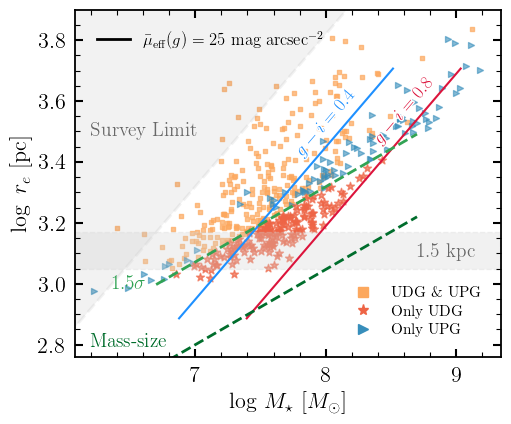

In [95]:
# new one
fig, ax2 = plt.subplots(figsize=(5.5, 4.6), sharey=True, sharex=True)


plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_e$ [pc]')


import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')

name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)
isudg = np.in1d(upg_cat['viz-id'], udg_cat['viz-id'])
sct = plt.scatter(
    upg_cat['log_m_star'][isudg], 
    np.log10(upg_cat['rhalf_phys'][isudg]) + 3, # in pc
    color=cmap(0.29), 
    marker='s', s=12,
    alpha=0.7)
sct = plt.scatter(
    upg_cat['log_m_star'][~isudg], 
    np.log10(upg_cat['rhalf_phys'][~isudg]) + 3, # in pc
    color=cmap(0.89), marker='>', s=18,
    alpha=0.6)

#----#
name = 'udg'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
udg_cat = udg_cat[udg_cat['viz-id'].data.data != 51815]
udg_cat.sort('g-i', reverse=True)
isupg = np.in1d(udg_cat['viz-id'], upg_cat['viz-id'])
sct = plt.scatter(
    udg_cat['log_m_star'][~isupg], 
    np.log10(udg_cat['rhalf_phys'][~isupg]) + 3, # in pc
    color=cmap(0.18), marker='*',
    alpha=0.7)


import matplotlib.lines as mlines
line2 = mlines.Line2D([], [], color='k', ls='-', lw=2, 
                      label=r'$\bar{\mu}_{\rm eff}(g)=25\ \mathrm{mag\ arcsec^{-2}}$')
leg = plt.legend(handles=[line2], loc='upper left', fontsize=12)
plt.gca().add_artist(leg)

dot1 = mlines.Line2D([], [], marker='s', color=cmap(0.29), ls='', markersize=7, label='UDG \& UPG')
dot2 = mlines.Line2D([], [], marker='*', color=cmap(0.18), ls='', markersize=8, label='Only UDG')
dot3 = mlines.Line2D([], [], marker='>', color=cmap(0.89), ls='', markersize=7, label='Only UPG')
plt.legend(handles=[dot1, dot2, dot3], fontsize=11, loc='lower right')


plt.sca(ax2)
plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
# plt.title(r'UPG $1.5 \sigma$')


dist = 100
g_mag = np.linspace(17.9, 22., 100)
g_abs = g_mag - 25 - 5 * np.log10(dist)
colors = ['dodgerblue', 'crimson']#['#f768a1','#c51b8a','#7a0177']
for i, gi in enumerate([0.4, 0.8]):
    log_ML_g = 1.297 * gi - 0.855
    log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
    SB = 25
    re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
    re_phys = (re_ang / 206265) * dist * 1000
    plt.plot(log_m_star, np.log10(re_phys) + 3, color=colors[i], 
             label=f'$g-i={gi}$')
from labellines import labelLines
labelLines(ax2.get_lines(), zorder=12, xvals=[8, 8.6], shrink_factor=0.2, fontsize=13, 
           outline_color='auto', outline_width=2, yoffsets=0.08)

### SB limit for the survey
dist = 100
g_mag = np.linspace(16.9, 25., 100)
g_abs = g_mag - 25 - 5 * np.log10(dist)
gi = 0.6
log_ML_g = 1.297 * gi - 0.855
log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
SB = 27.5
re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
re_phys = (re_ang / 206265) * dist * 1000
plt.fill_between(log_m_star, 
                 np.log10(re_phys) + 3, 
                 np.log10(re_phys) + 10, color='gray', ls='--', lw=2,
                 alpha=0.1)
plt.text(6.2, 3.5, 'Survey Limit', ha='left', va='center', fontsize=14, color='dimgray')

plt.fill_between(np.linspace(6.07, 9.34, 10), 3.05, 3.17, 
                 ls='--', color='lightgray', alpha=0.3)
plt.text(8.7, 3.1, '1.5 kpc', ha='left', va='center', fontsize=14, color='dimgray')


# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6.7, 8.7)
# colors = ['#74c476','#31a354','#006d2c']
colors = ['#31a354', '#006d2c']#[::-1] # '#31a354', '#74c476', 
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[0] - 0.07, mass_size_carlsten(x[0]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='right', va='center', fontsize=14, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[1], lw=2)
plt.text(x[0] + 0.09, mass_size_carlsten(x[0]) + 0.08, 
         f'Mass-size', ha='right', va='center', fontsize=14, color=colors[1])


plt.ylim(2.76, 3.9)
plt.xlim(6.0788956413363655, 9.346717212502009)

plt.subplots_adjust(wspace=0.05)

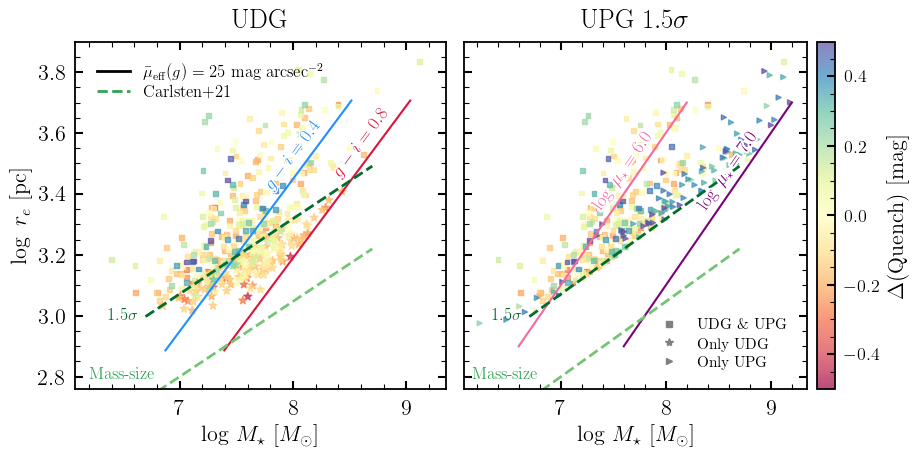

In [44]:
# OLD one
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(9.8, 4.6), sharey=True, sharex=True)

plt.sca(ax1)

name = 'udg'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
udg_cat.sort('g-i', reverse=True)

quenched_intercept = -0.23
V = udg_cat['mag'][:, 0] - 0.5784 * \
    (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(udg_cat['host_ang_diam_dist'].data *
                              (1 + udg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = -(udg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))
z = delta_MS

isupg = np.in1d(udg_cat['viz-id'], upg_cat['viz-id'])
sct = plt.scatter(
    udg_cat['log_m_star'][isupg], 
    np.log10(udg_cat['rhalf_phys'][isupg]) + 3, # in pc
    c=z[isupg], marker='s', s=12, vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)
sct = plt.scatter(
    udg_cat['log_m_star'][~isupg], 
    np.log10(udg_cat['rhalf_phys'][~isupg]) + 3, # in pc
    c=z[~isupg], marker='*', vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)

plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
plt.ylabel(r'$\log\ r_e$ [pc]')
plt.title(r'UDG')

# dist = 200
# g_mag = np.linspace(17.9, 22., 100)
# g_abs = g_mag - 25 - 5 * np.log10(dist)
# colors = ['dodgerblue', 'crimson']#['#f768a1','#c51b8a','#7a0177']
# for i, gi in enumerate([0.4, 0.8]):
#     log_ML_g = 1.297 * gi - 0.855
#     log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
#     SB = 25
#     re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
#     re_phys = (re_ang / 206265) * dist * 1000
#     plt.plot(log_m_star, np.log10(re_phys) + 3, color=colors[i], 
#              label=f'$g-i={gi}$')
# from labellines import labelLines
# labelLines(ax1.get_lines(), zorder=12, xvals=[8, 8.6], shrink_factor=0.2, fontsize=13, 
#            outline_color='auto', outline_width=2, yoffsets=0.08)

dist = 100
g_mag = np.linspace(17.9, 22., 100)
g_abs = g_mag - 25 - 5 * np.log10(dist)
colors = ['dodgerblue', 'crimson']#['#f768a1','#c51b8a','#7a0177']
for i, gi in enumerate([0.4, 0.8]):
    log_ML_g = 1.297 * gi - 0.855
    log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
    SB = 25
    re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
    re_phys = (re_ang / 206265) * dist * 1000
    plt.plot(log_m_star, np.log10(re_phys) + 3, color=colors[i], 
             label=f'$g-i={gi}$')
from labellines import labelLines
labelLines(ax1.get_lines(), zorder=12, xvals=[8, 8.6], shrink_factor=0.2, fontsize=13, 
           outline_color='auto', outline_width=2, yoffsets=0.08)

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6.7, 8.7)
# colors = ['#74c476','#31a354','#006d2c']
colors = ['#74c476','#31a354','#006d2c'][::-1]
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[0] - 0.07, mass_size_carlsten(x[0]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='right', va='center', fontsize=12, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[2], lw=2)
plt.text(x[0] + 0.09, mass_size_carlsten(x[0]) + 0.08, 
         f'Mass-size', ha='right', va='center', fontsize=12, color=colors[1])

# plt.axhline(np.log10(1500), 6.9, 8.2, ls='--', color='k')

import matplotlib.lines as mlines
line1 = mlines.Line2D([], [], color=colors[1], ls='--', lw=2, label=f'Carlsten+21')
line2 = mlines.Line2D([], [], color='k', ls='-', lw=2, 
                      label=r'$\bar{\mu}_{\rm eff}(g)=25\ \mathrm{mag\ arcsec^{-2}}$')
plt.legend(handles=[line2, line1], loc='upper left', fontsize=12)

plt.ylim(2.76, 3.9)
################################################################################
################################################################################
plt.sca(ax2)

name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)

quenched_intercept = -0.23
V = upg_cat['mag'][:, 0] - 0.5784 * \
    (upg_cat['mag'][:, 0] - upg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(upg_cat['host_ang_diam_dist'].data *
                              (1 + upg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = -(upg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))
z = delta_MS

isudg = np.in1d(upg_cat['viz-id'], udg_cat['viz-id'])

sct = plt.scatter(
    upg_cat['log_m_star'][isudg], 
    np.log10(upg_cat['rhalf_phys'][isudg]) + 3, # in pc
    c=z[isudg], marker='s', s=12, vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)
sct = plt.scatter(
    upg_cat['log_m_star'][~isudg], 
    np.log10(upg_cat['rhalf_phys'][~isudg]) + 3, # in pc
    c=z[~isudg], marker='>', s=13, vmin=-0.5, vmax=0.5, cmap='Spectral',
    alpha=0.7)
dot1 = mlines.Line2D([], [], marker='s', color='gray', ls='', markersize=5, label='UDG \& UPG')
dot2 = mlines.Line2D([], [], marker='*', color='gray', ls='', markersize=6, label='Only UDG')
dot3 = mlines.Line2D([], [], marker='>', color='gray', ls='', markersize=5, label='Only UPG')
leg = plt.legend(handles=[dot1, dot2, dot3], fontsize=11, loc='lower right')
# ax2.add_artist(leg)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(sct, cax=cax, label=r'$\Delta(\rm Quench)$ [mag]')
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(13)
        
plt.sca(ax2)
plt.xlabel(r'$\log\, M_\star\ [M_\odot]$')
plt.title(r'UPG $1.5 \sigma$')

### Iso surface mass density line ###
colors = ['#f768a1','#7a0177'] # '#c51b8a',
# log_m_star = np.linspace(6.8, 8.5, 100)
log_re = np.linspace(2.9, 3.7, 100) - 3
for i, log_mu_star in enumerate([6.0, 7.0]):
    log_m_star = 2 * log_re + log_mu_star + np.log10(2 * np.pi)
    plt.plot(log_m_star, log_re + 3, color=colors[i], label=f'$\log\ \mu_\star = {log_mu_star}$')
from labellines import labelLines
labelLines(ax2.get_lines(), zorder=12, xvals=[7.6, 8.6], shrink_factor=0.2, fontsize=13, 
           outline_color='auto', outline_width=3, yoffsets=0.08)

# Carlsten mass-size relation
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m
x = np.linspace(6.7, 8.7)
# colors = ['#74c476','#31a354','#006d2c']
colors = ['#74c476','#31a354','#006d2c'][::-1]
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[0] - 0.07, mass_size_carlsten(x[0]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='right', va='center', fontsize=12, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[2], lw=2)
plt.text(x[0] + 0.09, mass_size_carlsten(x[0]) + 0.08, 
         f'Mass-size', ha='right', va='center', fontsize=12, color=colors[1])

plt.subplots_adjust(wspace=0.05)

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/mass_size_plane.pdf', 
#             bbox_inches='tight', dpi=130)

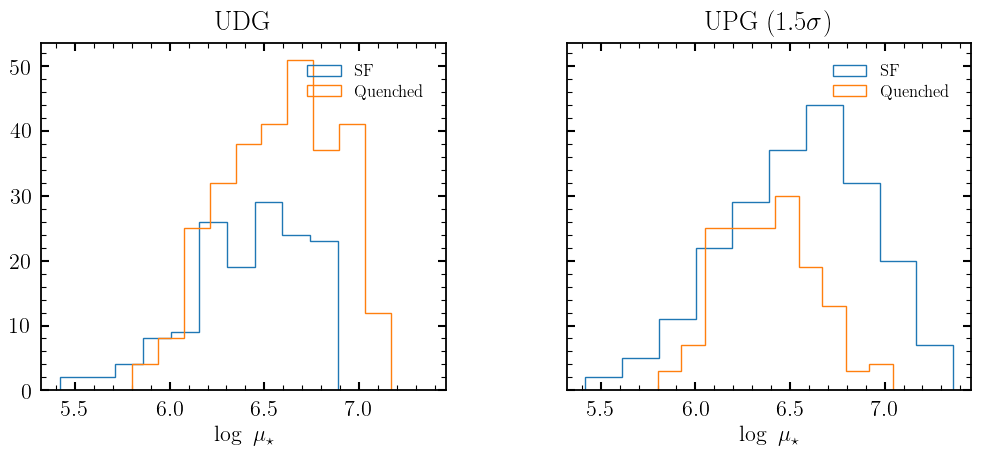

In [11]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4.6), sharey=True, sharex=True)

plt.sca(ax1)

name = 'udg'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
udg_cat.sort('g-i', reverse=True)

mu_mass = udg_cat['log_m_star'] - np.log10(np.pi * udg_cat['rhalf_phys']**2)
quenched_intercept = -0.23
V = udg_cat['mag'][:, 0] - 0.5784 * \
    (udg_cat['mag'][:, 0] - udg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(udg_cat['host_ang_diam_dist'].data *
                              (1 + udg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = (udg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))

plt.hist(mu_mass[delta_MS < 0], histtype='step', label='SF')
plt.hist(mu_mass[delta_MS > 0], histtype='step', label='Quenched')

plt.xlabel(r'$\log\ \mu_\star$')
plt.title(r'UDG')
plt.legend(fontsize=12)

####################
plt.sca(ax2)

name = 'upg'
thresh = 1.5
upg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
upg_cat = upg_cat[upg_cat['completeness'] > 0.1]
upg_cat.sort('g-i', reverse=True)

mu_mass = upg_cat['log_m_star'] - np.log10(np.pi * upg_cat['rhalf_phys']**2)
quenched_intercept = -0.23
V = upg_cat['mag'][:, 0] - 0.5784 * \
    (upg_cat['mag'][:, 0] - upg_cat['mag'][:, 1]) - 0.0038
V_abs = V - 25 - 5 * np.log10(upg_cat['host_ang_diam_dist'].data *
                              (1 + upg_cat['host_z'].data)**2)
# The criterion for quenching is from Carlsten+22. 
# The original intercept is -0.23. I think 0.28 works better for our sample.
delta_MS = (upg_cat['g-i'] - (-0.067 * V_abs + quenched_intercept))

plt.hist(mu_mass[delta_MS < 0], histtype='step', label='SF')
plt.hist(mu_mass[delta_MS > 0], histtype='step', label='Quenched')

plt.xlabel(r'$\log\ \mu_\star$')
plt.title(r'UPG ($1.5\sigma$)')
plt.legend(fontsize=12)


plt.subplots_adjust(wspace=0.3)

### $R_e-M_V$ plot

In [4]:
from paper_figure import plot_size_distribution

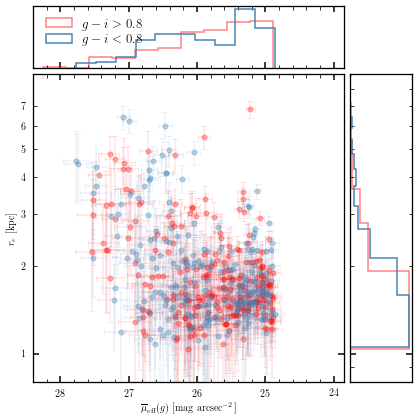

In [7]:
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]

# udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

# Distribution of the full sample after junk cuts
fig, ax = plt.subplots(figsize=(6, 6))

red = (udg_cat['g-i'].data > 0.8)

markers, caps, bars = ax.errorbar(udg_cat[red]['SB_eff_avg'][:, 0], 
            udg_cat[red]['rhalf_phys'], 
            xerr=udg_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[red]['rhalf_phys_err'],
            color='r', fmt='o', ms=5, alpha=0.3, label='$g-i > 0.8$')
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

markers, caps, bars = ax.errorbar(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_phys'], 
            xerr=udg_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[~red]['rhalf_phys_err'],
            color='steelblue', fmt='o', ms=5, alpha=0.35, label='$g-i < 0.8$')
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

ax.set_xlim(28.4, 23.85)
ax.set_ylim(0.8, 9)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor', right=False)
ax.set_yticks([1], minor=False)
ax.set_yticklabels([1], minor=False)
ax.set_yticks([2, 3, 4, 5, 6, 7], minor=True)
ax.set_yticklabels([2, 3, 4, 5, 6, 7], minor=True)

ax_histx = ax.inset_axes((0, 1.02, 1, .2))
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=1.5,
              histtype='step', density=True, color='r', alpha=0.5, label='$g-i > 0.8$')
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=1.5,
              histtype='step', density=True, color='steelblue', label='$g-i < 0.8$')
ax_histx.set_xlim(ax.get_xlim())

ax_histy = ax.inset_axes((1.02, 0, 0.2, 1))
ax_histy.tick_params(axis="y", which='both', labelleft=False)
ax_histy.hist(udg_cat[red]['rhalf_phys'], lw=1.5,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_phys'], lw=1.5,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_yscale('log')
ax_histy.set_ylim(ax.get_ylim())

ax_histx.set_yticks([])
ax_histy.set_xticks([])
leg = ax_histx.legend(loc=(0.02, 0.26), frameon=False, fontsize=13)

### Host property
# axins = ax.inset_axes((0.5, 1-0.3, .3, .15), )
# axins.hist(udg_cat['host_z'], histtype='step', density=True, color='gray')
# axins.set_yticks([])
# axins.set_xticks([0.02, 0.04])
# axins.set_xticklabels([0.02, 0.04], fontsize=10)

plt.tight_layout()

---

In [143]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=18)

In [144]:
from paper_figure import re_SB_distribution

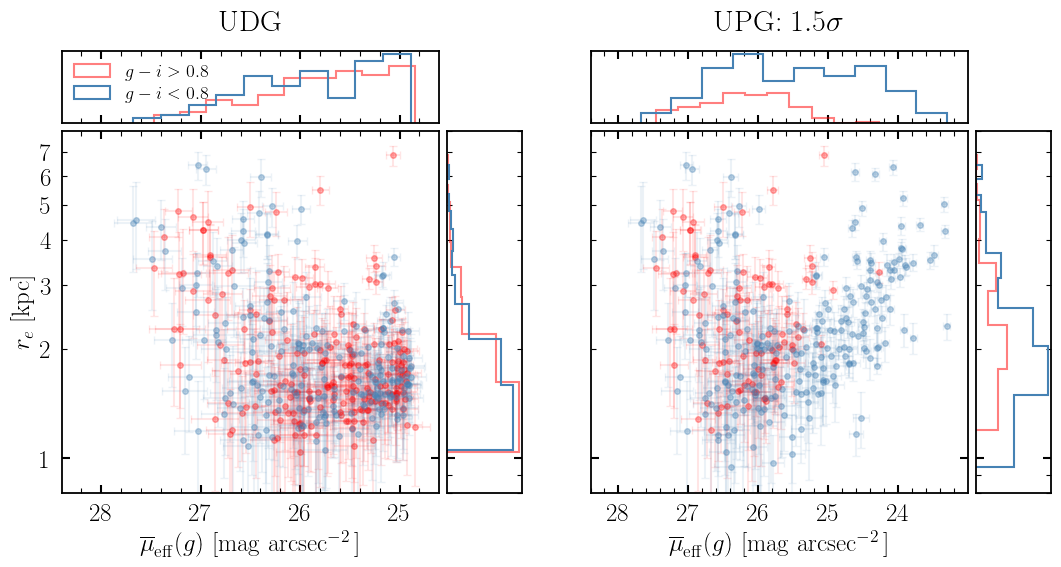

In [146]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11.7, 4.8), sharey=True)

name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25.0)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fig, ax1 = re_SB_distribution(udg_cat, ax=ax1, xlim=(28.4, 24.6))
ax1[1].set_title("UDG", y=1.1)


name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fig, ax2 = re_SB_distribution(udg_cat, ax=ax2, xlim=(28.4, 23), show_legend=False)
ax2[0].set_ylabel('')
ax2[0].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[0].set_xticks(np.arange(28.4, 23, -0.2), minor=True)
ax2[1].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[1].set_xticks(np.arange(28.4, 23, -0.2), minor=True)

ax2[1].set_title("UPG: $1.5\sigma$", y=1.1)

plt.subplots_adjust(wspace=0.4)
# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/udg_upg_sample.pdf', 
#             bbox_inches='tight', dpi=120)

In [80]:
import matplotlib
cmap = matplotlib.cm.get_cmap('coolwarm')
norm = matplotlib.colors.Normalize(vmin=0.2, vmax=1.2)

Text(0, 0.5, '$R_e$ [kpc]')

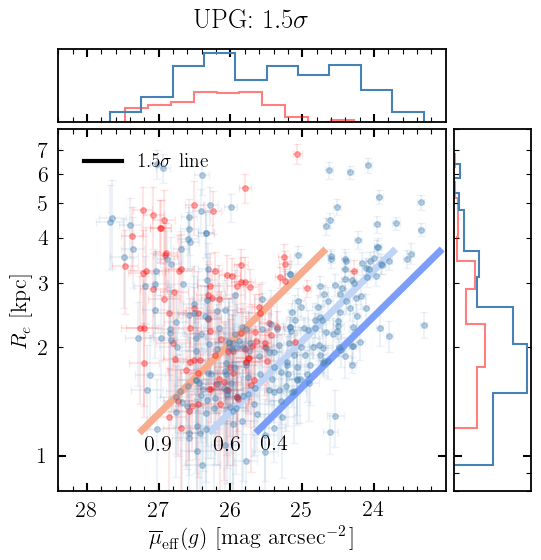

In [88]:
fig, ax2 = plt.subplots(figsize=(5, 4.8), sharey=True)

name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fig, ax2 = re_SB_distribution(udg_cat, ax=ax2, xlim=(28.4, 23), show_legend=False)
ax2[0].set_ylabel('')
ax2[0].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[0].set_xticks(np.arange(28.4, 23, -0.2), minor=True)
ax2[1].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[1].set_xticks(np.arange(28.4, 23, -0.2), minor=True)

ax2[1].set_title("UPG: $1.5\sigma$", y=1.1)


dist = 100

for gi in [0.4, 0.6, 0.9]:
    # Carlsten mass-size relation
    def mass_size_carlsten(log_m):
        return 1.071 + 0.247 * log_m

    log_m_star = np.linspace(7, 9, 100)
    log_ML_g = 1.297 * gi - 0.855
    g_abs = -1 * (log_m_star - log_ML_g) * 2.5 + 5.03
    g_mag = g_abs + 25 + 5 * np.log10(dist)

    re_phys = 10**(mass_size_carlsten(log_m_star) + 1.5 * 0.181 - 3)
    re_ang = re_phys / (dist * 1000) * 206265
    SB = g_mag + 2.5 * np.log10(2 * np.pi * re_ang**2)
    l = ax2[0].plot(SB, re_phys, lw=5, c=cmap(norm(gi)))
    ax2[0].text(SB[1], re_phys[1] - 0.05, str(gi), ha='left', va='top')
    
line2 = mlines.Line2D([], [], ls='-', c='k', lw=3, label=r'$1.5\sigma\ \mathrm{line}$')
plt.legend(handles=[line2], loc='upper left', fontsize=14)

plt.ylabel('$R_e$ [kpc]')

In [105]:
np.sqrt(0.04**2 + 0.2**2)

0.20396078054371142

In [107]:
36 / 20 / 6

0.3

In [109]:
13 / 10 / (30 * 6)

0.007222222222222223

In [111]:
412 / 901 * 0.8

0.36581576026637075

In [112]:
412 / 258

1.5968992248062015

In [114]:
412 / 901

0.4572697003329634

(28.0, 23.0)

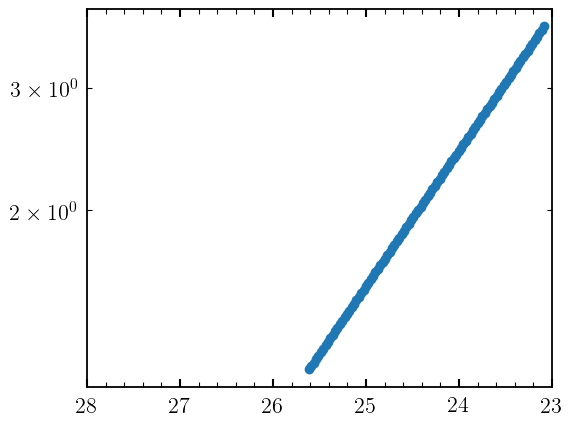

In [53]:
plt.scatter(SB, re_phys)

plt.yscale('log')
plt.xlim(28, 23)

In [ ]:
np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))

In [ ]:
SB = 

In [ ]:

log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
SB = 25
re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
re_phys = (re_ang / 206265) * dist * 1000

In [ ]:

colors = ['dodgerblue', 'crimson']#['#f768a1','#c51b8a','#7a0177']
for i, gi in enumerate([0.4, 0.8]):
    log_ML_g = 1.297 * gi - 0.855
    log_m_star = -0.4 * (g_abs - 5.03) + log_ML_g
    SB = 25
    re_ang = np.sqrt(10**(0.4 * (SB - g_mag)) / (2 * np.pi))
    re_phys = (re_ang / 206265) * dist * 1000
    label = 'Blue' if i==0 else 'Red'
    plt.plot(log_m_star, np.log10(re_phys) + 3, color=colors[i], 
             label=label + ' UDG cut')
from labellines import labelLines
labelLines(ax2.get_lines(), zorder=12, xvals=[8.3, 8.9], shrink_factor=0.2, fontsize=13, 
           outline_color='auto', outline_width=2, yoffsets=0.08)



x = np.linspace(6.7, 8.9)
colors = ['#31a354', '#006d2c']
for i, sigma in enumerate([1.5]):
    ms1 = plt.plot(x, mass_size_carlsten(x) + 0.181 * sigma, ls='--', 
             color=colors[i], lw=2)
    plt.text(x[-6] + 0.19, mass_size_carlsten(x[-6]) + 0.181 * sigma, 
             f'${sigma}\sigma$', ha='left', va='center', fontsize=12, color=colors[i])

ms1 = plt.plot(x, mass_size_carlsten(x), ls='--', 
               color=colors[1], lw=2)

### UDG fraction

In [356]:
# date = '220726'
date = '221025'

In [357]:
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area occupied by detected UDG hosts [deg2]:', total_area)

Total angular area [deg2]: 32.70887732960614


In [370]:
lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')])
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z001_004_missed.fits')])
imcomplete_file_ind = np.sort(lsbg_cat[~np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]['viz-id'].data)
print('Number of incomplete files:', len(imcomplete_file_ind))
print('Valid number of objects:', len(lsbg_cat) - len(imcomplete_file_ind))
lsbg_cat = lsbg_cat[np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]
print(len(lsbg_cat))
cuts_cat = lsbg_cat
cuts_cat['host_gi'] = np.zeros(len(cuts_cat))

Number of incomplete files: 65
Valid number of objects: 10579
10579


In [361]:
# input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
# from sample_cuts import post_process_cat_new_rbf
# cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

In [371]:
_, ind = np.unique(cuts_cat['host_name'].data, return_index=True)
total_area_all = (np.pi * (cuts_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area_all)

Total angular area [deg2]: 89.19904707251214


In [409]:
fake_udg_cat = Table.read(f'./Catalog/random_field/fake_udg_cat_{date}.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg
print(density_bkg)
len(fake_udg_cat)

1.5885416666666667


In [377]:
UDG_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{date}_{name}_num.npy')
density_bkg = np.mean(UDG_num) / 24
density_std = np.std(UDG_num) / 24

In [390]:
n_udg = (len(udg_cat) - density_bkg * total_area_all) / len(np.unique(cuts_cat['host_name']))
n_udg_std = np.sqrt(len(udg_cat) - density_bkg * total_area_all) / len(np.unique(cuts_cat['host_name']))
n_udg_std = np.sqrt(n_udg_std**2 + (density_std * total_area_all / len(np.unique(cuts_cat['host_name'])))**2)
n_udg *= (1 / udg_cat['completeness']).mean()
n_udg_std *= (1 / udg_cat['completeness']).mean()

In [375]:
np.sqrt(len(udg_cat) - density_bkg * total_area_all) / len(np.unique(cuts_cat['host_name']))

0.01783179207721995

In [376]:
(0.23 * total_area_all) / len(np.unique(cuts_cat['host_name']))

0.022251389182947716

In [392]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('n(UDG):', n_udg, '+-', n_udg_std)
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', n_udg, '+-', n_udg_std)
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 922

LSBGs after cuts: 10579
UDGs: 412
n(UDG): 0.4427068850184662 +- 0.04560391070186532
UDG hosts: 258
UDG fraction: 0.4427068850184662 +- 0.04560391070186532

# of Candy: 340
# of Gal: 61
# of Junk: 11


In [307]:
0.6119883667389118 / 6

0.10199806112315196

In [393]:
## assumeeach MW has 5 satellites. Then the fraction of UDG out of all MW satellites:
n_udg / 6, n_udg / 5, n_udg / 7

(0.07378448083641104, 0.08854137700369324, 0.06324384071692375)

In NGVS, they have 15 UDGs out of 404 satellites.

In [22]:
15 / 404

0.03712871287128713

In [2]:
24 / 404

0.0594059405940594

## UPG

In [394]:
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
# udg_cat = udg_cat[udg_cat['log_m_star'] <= 8.5]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

Total angular area [deg2]: 32.36912377009267


In [395]:
len(udg_cat)

337

In [396]:
# input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
# from sample_cuts import post_process_cat_new_rbf
# cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

In [397]:
lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')])
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z001_004_missed.fits')])
imcomplete_file_ind = np.sort(lsbg_cat[~np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]['viz-id'].data)
print('Number of incomplete files:', len(imcomplete_file_ind))
print('Valid number of objects:', len(lsbg_cat) - len(imcomplete_file_ind))
lsbg_cat = lsbg_cat[np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]
print(len(lsbg_cat))
cuts_cat = lsbg_cat
cuts_cat['host_gi'] = np.zeros(len(cuts_cat))

Number of incomplete files: 65
Valid number of objects: 10579
10579


In [398]:
_, ind = np.unique(cuts_cat['host_name'].data, return_index=True)
total_area_all = (np.pi * (cuts_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area_all)

Total angular area [deg2]: 89.19904707251214


In [411]:
fake_udg_cat = Table.read(f'./Catalog/random_field/fake_upg_cat_{thresh}sigma_{date}.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]
density_bkg = len(fake_udg_cat) / (10 * 20) / 24 # bkg per sqr deg
print(density_bkg)
len(fake_udg_cat)

1.7222916666666668


8267

In [402]:
UDG_num = np.load(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_{date}_{name}_num.npy')
density_bkg = np.mean(UDG_num) / 24
density_std = np.std(UDG_num) / 24

In [403]:
density_bkg, density_std

(1.7222916666666668, 0.2251649665307145)

In [404]:
n_udg = (len(udg_cat) - density_bkg * total_area_all) / len(np.unique(cuts_cat['host_name']))
n_udg_std = np.sqrt(len(udg_cat) - density_bkg * total_area_all) / len(np.unique(cuts_cat['host_name']))
n_udg_std = np.sqrt(n_udg_std**2 + (density_std * total_area_all / len(np.unique(cuts_cat['host_name'])))**2)
n_udg *= (1 / udg_cat['completeness']).mean()
n_udg_std *= (1 / udg_cat['completeness']).mean()

In [405]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UPGs:', len(udg_cat))
print('UPG hosts:', len(np.unique(udg_cat['host_name'])))

print('UPG fraction:', n_udg, '+-', n_udg_std)

print('UPG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 922

LSBGs after cuts: 10579
UPGs: 337
UPG hosts: 239
UPG fraction: 0.31012802737443895 +- 0.040967124943651796
UPG fraction: 0.36550976138828634

# of Candy: 288
# of Gal: 41
# of Junk: 8


In [406]:
## assumeeach MW has 5 satellites. Then the fraction of UDG out of all MW satellites:
n_udg / 6, n_udg / 5, n_udg / 7

(0.05168800456240649, 0.06202560547488779, 0.04430400391063414)

In [414]:
0.4 / (np.sqrt(0.04**2 + 0.16**2))

2.4253562503633295

#### Simple exp

Let's assume that we have 700 galaxies to be searched. Intrinsically, each host has 0.5 UDG. Let's populate them

In [332]:
n_hosts = 5000

udg_abundance = 0.5 # per host
density_bkg = 2 # per deg2
host_area = 0.1 # per host

In [325]:
udg_ids = np.random.poisson(udg_abundance, size=n_hosts)

In [326]:
print('# of UDGs / # of hosts',udg_ids.sum() / n_hosts)

# of UDGs / # of hosts 0.5032


In [327]:
print('# of hosts with >0 UDGs', np.sum(udg_ids > 0))

# of hosts with >0 UDGs 1960


Each galaxy span 0.1 deg2 on the sky. And the contam density is 2 per deg2. So on average, each galaxy has 0.2 contam. 

In [333]:
fake_ids = np.random.poisson(density_bkg * host_area, size=n_hosts)

In [334]:
obs_ids = udg_ids + fake_ids

In [335]:
print('# of observed UDGs / # of hosts', obs_ids.sum() / n_hosts)

# of observed UDGs / # of hosts 0.6976


In [337]:
print('# of hosts with >0 UDGs after contam', np.sum(obs_ids > 0))

# of hosts with >0 UDGs after contam 2505


In [338]:
n_udg = (np.sum(obs_ids) - density_bkg * host_area * np.sum(obs_ids > 0)) / n_hosts

In [339]:
print('UDG abundance', n_udg)

UDG abundance 0.5974


In [340]:
n_udg = (np.sum(obs_ids) - density_bkg * host_area * len(obs_ids > 0)) / n_hosts

In [341]:
print('UDG abundance', n_udg)

UDG abundance 0.4976


In [245]:
n_udg = (np.sum(udg_ids + fake_ids) - 0.2 * n_hosts) / n_hosts
n_udg_std = np.sqrt((np.sum(udg_ids + fake_ids) - 0.2 * n_hosts)) / n_hosts

In [246]:
n_udg, n_udg_std

(0.5078571428571429, 0.01904613089424769)

In [283]:
np.sum(fake_ids) / np.sum(fake_ids + udg_ids)

0.2853477765108324

In [280]:
1.94 * 32.37 / (412)

0.15242184466019415

In [284]:
2.12 * 75.94 / (337)

0.4777234421364986